
ADVANCED PALS ANALYSIS EXAMPLES

Example 2: Effect of Diffusion Length
Testing diffusion lengths: [  3  30  75 100 200]
Saved: diffusion_length_effect.pdf

Example 3: S-Parameter Heatmap
Computing 50 × 50 grid points...
Saved: thickness_heatmap.pdf

Example 5: Annihilation Profile Heatmap
Saved: true_diffusion_heatmap.pdf

ALL EXAMPLES COMPLETE

Generated files:
  - sensitivity_interface_width.pdf
  - diffusion_length_effect.pdf
  - thickness_heatmap.pdf
  - monte_carlo_distributions.pdf


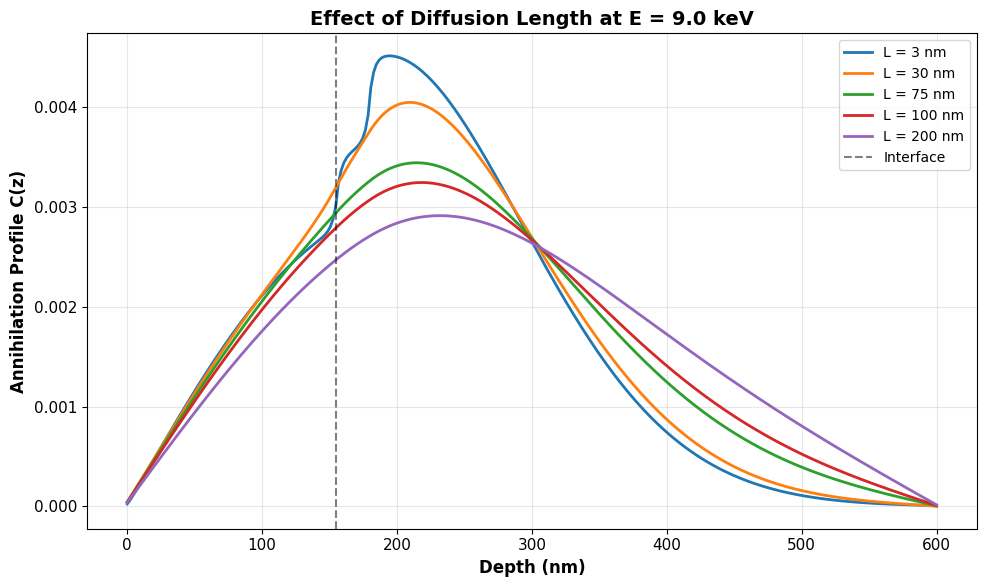

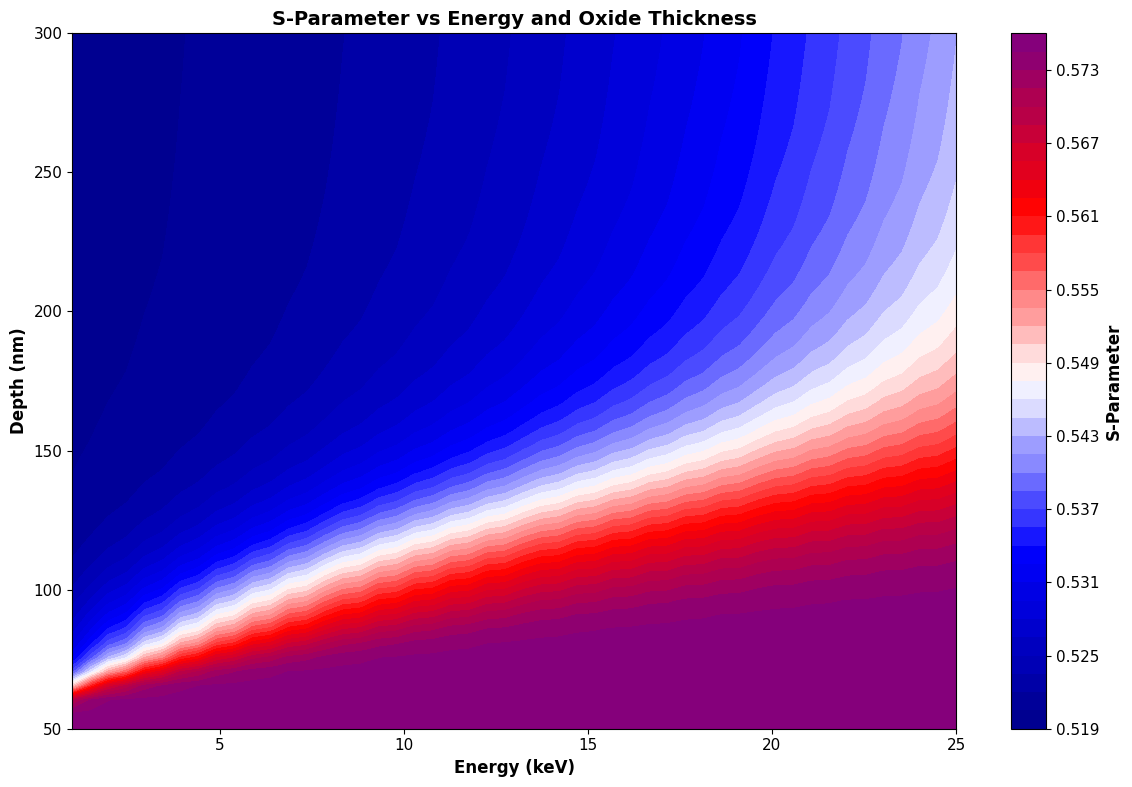

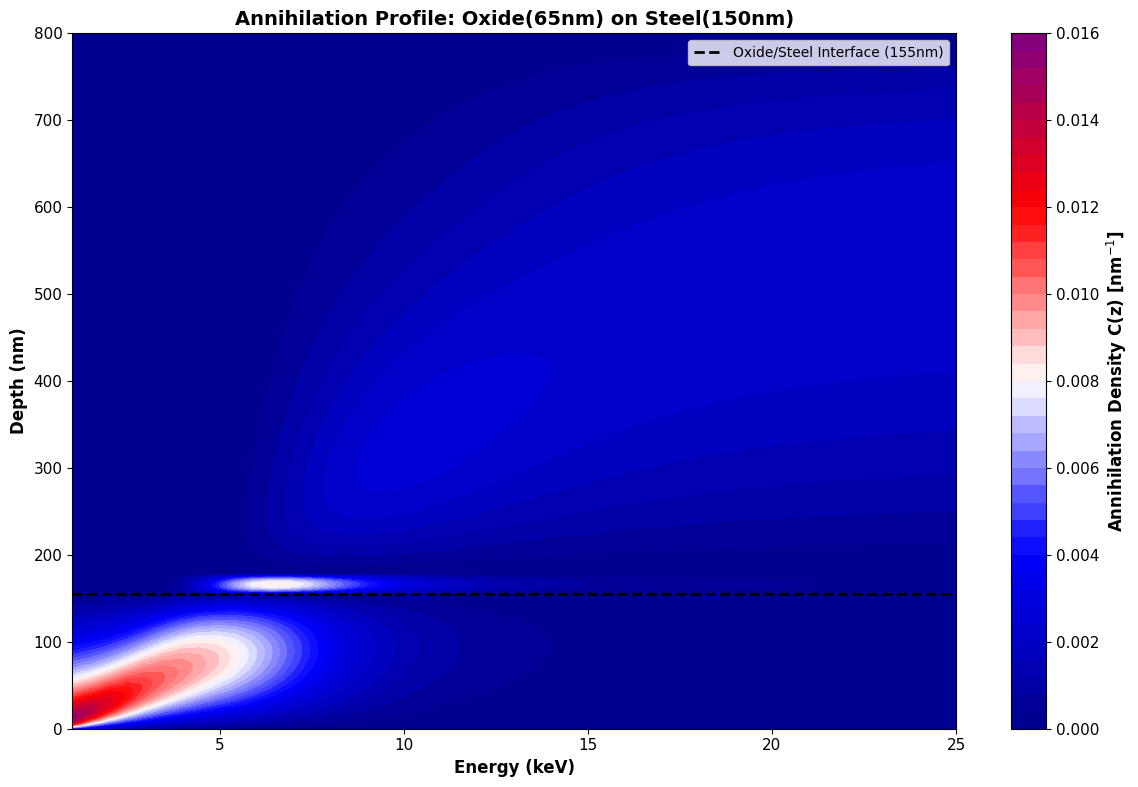

In [ ]:
"""Advanced analysis examples showing sensitivity studies and heatmaps."""

import sys
sys.path.insert(0, r'C:\Users\jeanv\OneDrive - Delft University of Technology\Uitwisseling - TUDelft\Courses\MEP\Programming')

import numpy as np
import matplotlib.pyplot as plt
from pals_analysis import config
from pals_analysis.physics import makhov_profile, calculate_annihilation_profile
from pals_analysis.analysis import (
    solve_for_thickness,
    study_interface_width,
    study_diffusion_length,
    study_layer_thickness,
    monte_carlo_uncertainty
)
from pals_analysis.visualization import (
    setup_plot_style,
    plot_s_parameter_fit,
    plot_depth_profiles,
    create_heatmap,
    plot_parameter_sensitivity
)

setup_plot_style()


def example_1_sensitivity_to_interface_width():
    """Show how interface blurring affects fitted thickness."""
    print("=" * 70)
    print("Example 1: Sensitivity to Interface Width")
    print("=" * 70)
    
    # Base configuration
    base_layers = [
        {'thickness': 155, 'density': 5.24, 'L_diff': 30},
        {'thickness': 1000, 'density': 8.00, 'L_diff': 150}
    ]
    
    # Test different interface widths
    width_values = np.array([0, 5, 10, 20, 30, 50, 100])
    
    # Use your experimental data
    energies = config.YOUR_DATA[:, 0]
    s_exp = config.YOUR_DATA[:, 1]
    
    print(f"Testing {len(width_values)} interface widths...")
    results = study_interface_width(energies, s_exp, base_layers, width_values)
    
    print(f"\nResults:")
    for w, d in zip(results['widths'], results['thicknesses']):
        print(f"  Width = {w:3.0f} nm  →  Fitted thickness = {d:.1f} nm")
    
    # Plot sensitivity
    plot_parameter_sensitivity(
        results['widths'], 
        results['thicknesses'],
        'Interface Width (nm)',
        'Fitted Thickness (nm)',
        save_as='sensitivity_interface_width.pdf'
    )
    
    print()


def example_2_diffusion_length_effect():
    """Show how diffusion length affects annihilation profile."""
    print("=" * 70)
    print("Example 2: Effect of Diffusion Length")
    print("=" * 70)
    
    base_layers = [
        {'thickness': 155, 'density': 5.24, 'L_diff': 30},
        {'thickness': 25, 'density': 6.50, 'L_diff': 1},
        {'thickness': 1000, 'density': 8.00, 'L_diff': 150}
    ]
    
    L_values = np.array([3, 30, 75, 100, 200])
    energy = 9.0
    
    print(f"Testing diffusion lengths: {L_values}")
    results = study_diffusion_length(energy, base_layers, L_values)
    
    # Plot profiles for different L values
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for i, L in enumerate(L_values):
        ax.plot(results['z'], results['profiles'][i], 
                label=f'L = {L} nm', linewidth=2)
    
    ax.axvline(155, color='black', linestyle='--', alpha=0.5, label='Interface')
    ax.set_xlabel('Depth (nm)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Annihilation Profile C(z)', fontsize=12, fontweight='bold')
    ax.set_title(f'Effect of Diffusion Length at E = {energy} keV', 
                 fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('diffusion_length_effect.pdf', dpi=300)
    print("Saved: diffusion_length_effect.pdf\n")


def example_3_thickness_heatmap():
    """Create heatmap showing S-parameter vs energy and thickness."""
    print("=" * 70)
    print("Example 3: S-Parameter Heatmap")
    print("=" * 70)
    
    base_layers = [
        {'thickness': 100, 'density': 5.24, 'L_diff': 30},
        {'thickness': 25, 'density': 6.50, 'L_diff': 1},
        {'thickness': 1000, 'density': 8.00, 'L_diff': 150}
    ]
    
    # Parameter ranges
    energies = np.linspace(1, 25, 50)
    thickness_values = np.linspace(50, 300, 50)
    
    print(f"Computing {len(energies)} × {len(thickness_values)} grid points...")
    
    results = study_layer_thickness(energies, thickness_values, base_layers)
    
    # Create heatmap
    create_heatmap(
        energies,
        thickness_values,
        results['s_curves'],
        title='S-Parameter vs Energy and Oxide Thickness',
        save_as='thickness_heatmap.pdf'
    )
    
    print()


def example_4_monte_carlo_uncertainty():
    """Estimate uncertainty using Monte Carlo simulation."""
    print("=" * 70)
    print("Example 4: Monte Carlo Uncertainty Analysis")
    print("=" * 70)
    
    energies = config.YOUR_DATA[:, 0]
    s_exp = config.YOUR_DATA[:, 1]
    s_err = np.full_like(s_exp, 0.002)  # Assume 0.002 uncertainty
    
    print("Running 500 Monte Carlo iterations...")
    results = monte_carlo_uncertainty(energies, s_exp, s_err, n_iterations=500)
    
    print(f"\nResults:")
    print(f"  Thickness: {results['thickness_mean']:.2f} ± {results['thickness_std']:.2f} nm")
    print(f"  S-surface: {results['s_surface_mean']:.4f} ± {results['s_surface_std']:.4f}")
    
    # Plot distributions
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    ax1.hist(results['thickness_values'], bins=30, color='blue', alpha=0.7, edgecolor='black')
    ax1.axvline(results['thickness_mean'], color='red', linestyle='--', linewidth=2,
                label=f"Mean: {results['thickness_mean']:.1f} nm")
    ax1.set_xlabel('Thickness (nm)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Frequency', fontsize=12, fontweight='bold')
    ax1.set_title('Thickness Distribution', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    ax2.hist(results['s_surface_values'], bins=30, color='green', alpha=0.7, edgecolor='black')
    ax2.axvline(results['s_surface_mean'], color='red', linestyle='--', linewidth=2,
                label=f"Mean: {results['s_surface_mean']:.4f}")
    ax2.set_xlabel('S-Parameter', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Frequency', fontsize=12, fontweight='bold')
    ax2.set_title('S-Parameter Distribution', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('monte_carlo_distributions.pdf', dpi=300)
    print("Saved: monte_carlo_distributions.pdf\n")

def example_5_diffusion_heatmap(L_value):
    """Create heatmap showing Annihilation profile vs energy and thickness."""

    """
    input parameters:
    L_value : list with diffusion length
    """

    print("=" * 70)
    print("Example 5: Annihilation Profile Heatmap")
    print("=" * 70)
    
    # 1. Define your specific structure (Oxide=65, Steel=150)
    base_layers = [
        {'thickness': 155, 'density': 5.24, 'L_diff': 65},
        {'thickness': 25, 'density': 6.50, 'L_diff': 10},
        {'thickness': 1000, 'density': 8.00, 'L_diff': 150}
    ]
    
    energies = np.linspace(1, 25, 50)
    z_grid = np.linspace(0, 800, 400)
    
    profile_results = []
    
    # 2. Loop through energies and call physics directly
    for E in energies:
        # Step A: Implantation (Makhov)
        p_z = makhov_profile(z_grid, E, base_layers)
        
        # Step B: Annihilation (Diffusion)
        # This function respects the list of layers, so it keeps 65 and 150 separate!
        c_z = calculate_annihilation_profile(z_grid, p_z, base_layers)
        
        profile_results.append(c_z)

    # 3. Plot
    create_heatmap(
        energies, 
        z_grid,
        np.array(profile_results),
        title='Annihilation Profile: Oxide(65nm) on Steel(150nm)',
        d_ox=155,
        cbar_label=r'Annihilation Density C(z) [nm$^{-1}$]',
        save_as='true_diffusion_heatmap.pdf'
    )

    
    print()

    
    
def main():
    """Run all advanced examples."""
    print("\n" + "=" * 70)
    print("ADVANCED PALS ANALYSIS EXAMPLES")
    print("=" * 70 + "\n")
    
    # example_1_sensitivity_to_interface_width()
    example_2_diffusion_length_effect()
    example_3_thickness_heatmap()
    # example_4_monte_carlo_uncertainty()
    example_5_diffusion_heatmap(L_value=[65,30,150])
    
    print("=" * 70)
    print("ALL EXAMPLES COMPLETE")
    print("=" * 70)
    print("\nGenerated files:")
    print("  - sensitivity_interface_width.pdf")
    print("  - diffusion_length_effect.pdf")
    print("  - thickness_heatmap.pdf")
    print("  - monte_carlo_distributions.pdf")
    
    plt.show()


if __name__ == "__main__":
    main()


RUNNING PALS PHYSICS SIMULATION
Simulating 50 energy points...
Generating plots...


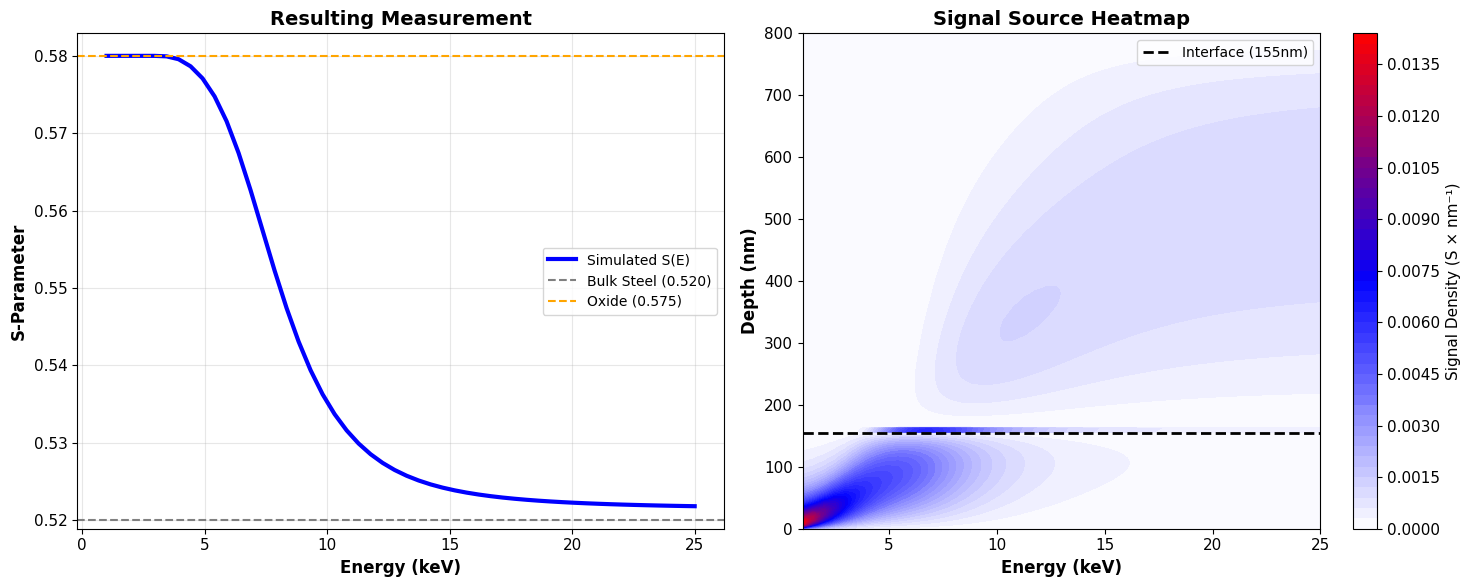

Done! Saved to 'test_physics_result.pdf'


In [24]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Import your physics engine
from pals_analysis.physics.implantation import makhov_profile
from pals_analysis.physics.annihilation import calculate_annihilation_profile

def run_simulation_test():
    print("=" * 60)
    print("RUNNING PALS PHYSICS SIMULATION")
    print("=" * 60)

    # ---------------------------------------------------------
    # 1. SETUP: Define the Material Structure
    # ---------------------------------------------------------
    # We define a 155nm Oxide on Steel.
    # Note: L_diff is 30nm for Oxide, 150nm for Steel.
    layers = [
        {'thickness': 155,  'density': 5.24, 'L_diff': 30},   # Layer 0: Oxide
        {'thickness': 10,  'density': 6.50, 'L_diff': 0.01},   # Layer 0: Oxide
        {'thickness': 1000, 'density': 8.00, 'L_diff': 150}   # Layer 1: Steel
    ]
    
    # Define S-parameters for each material (Pure values)
    S_OXIDE = 0.580
    S_STEEL = 0.520
    
    # Simulation grid
    energies = np.linspace(1, 25, 50)  # Energy from 1 to 25 keV
    z_grid = np.linspace(0, 800, 400)  # Depth from 0 to 800 nm

    # ---------------------------------------------------------
    # 2. PHYSICS LOOP: Calculate Profiles
    # ---------------------------------------------------------
    print(f"Simulating {len(energies)} energy points...")
    
    s_curve = []
    signal_map = [] # To store the 2D signal data
    
    # Create the 'True' S-parameter map of the sample (Step function)
    # This is S(z): 0.575 before 155nm, 0.520 after
    # CORRECT LOGIC for 3 Layers (Surface -> Bulk -> Steel)
    s_z_map = np.zeros_like(z_grid)

    # Layer 0: Surface Trap (0 to 10nm)
    s_z_map[z_grid < 155] = S_OXIDE  # High Surface S

    # Layer 1: Bulk Oxide (155 to 165nm)
    mask_oxide = (z_grid >= 155) & (z_grid < 165)
    s_z_map[mask_oxide] = 0.540   # Low Bulk S (The Dip!)

    # Layer 2: Steel (> 165nm)
    s_z_map[z_grid >= 165] = 0.520 # Steel S

    for E in energies:
        # A. Implantation (Makhov)
        # Calculates where positrons stop based on Density
        p_z = makhov_profile(z_grid, E, layers)
        
        # B. Diffusion (Annihilation)
        # Calculates where they die based on Diffusion Length
        c_z = calculate_annihilation_profile(z_grid, p_z, layers)
        
        # C. Measurement (S-Parameter)
        # Integral of [Probability Density * Local S-Value]
        local_signal = c_z * s_z_map
        s_value = np.trapezoid(local_signal, z_grid)
        
        s_curve.append(s_value)
        signal_map.append(local_signal)

    s_curve = np.array(s_curve)
    signal_map = np.array(signal_map) # Shape: (Energies, Depths)

    # ---------------------------------------------------------
    # 3. VISUALIZATION
    # ---------------------------------------------------------
    print("Generating plots...")
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # PLOT 1: The S-Parameter Curve
    ax1.plot(energies, s_curve, 'b-', linewidth=3, label='Simulated S(E)')
    ax1.axhline(S_STEEL, color='gray', linestyle='--', label='Bulk Steel (0.520)')
    ax1.axhline(S_OXIDE, color='orange', linestyle='--', label='Oxide (0.575)')
    ax1.set_xlabel('Energy (keV)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('S-Parameter', fontsize=12, fontweight='bold')
    ax1.set_title('Resulting Measurement', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    # PLOT 2: The Signal Contribution Heatmap
    # This shows S(z) * C(z), effectively "Where the signal comes from"
    
    # Custom colormap (White -> Blue -> Red)
    cmap = LinearSegmentedColormap.from_list('signal', ['white', 'blue', 'red'], N=100)
    
    im = ax2.contourf(energies, z_grid, signal_map.T, levels=50, cmap=cmap)
    
    # Draw the Interface Line
    ax2.axhline(155, color='black', linestyle='--', linewidth=2, label='Interface (155nm)')
    
    ax2.set_xlabel('Energy (keV)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Depth (nm)', fontsize=12, fontweight='bold')
    ax2.set_title('Signal Source Heatmap', fontsize=14, fontweight='bold')
    ax2.legend(loc='upper right')
    
    # Colorbar
    cbar = plt.colorbar(im, ax=ax2)
    cbar.set_label('Signal Density (S × nm⁻¹)', fontsize=11)

    plt.tight_layout()
    plt.savefig('test_physics_result.pdf', dpi=300)
    plt.show()
    print("Done! Saved to 'test_physics_result.pdf'")

if __name__ == "__main__":
    run_simulation_test()